# Project structure:

```
stockai
├── __init__.py
├── __main__.py
├── app.py
├── config
│   ├── __init__.py
│   └── config.py
├── data_collection
│   ├── __init__.py
│   ├── extract_text.py
│   ├── extract_urls.py
│   ├── geckodriver
│   ├── logs
│   │   ├── extract_urls.log
│   │   └── multi_text_extraction.log
│   ├── newsapi.py
│   └── stocknewsapi_com.py
├── data_prep
│   └── fix_date.py
└── ml
    └── __init__.py
```

## Data Collection

1. `data_collection/extract_urls.py` extracts URLs for news articles related to S&P500 companies. 
    1. Main sources:
        1. Yahoo news
        2. finviz.com
        3. *usanews* subreddit
    2. Additional sources:
        1. `newsapi.py` Newsapi and 20+ media outlets
        2. `stocknewsapi_com.py` convenient source of URLs from February 2018+
2. `data_collection/extract_text.py` visits URLs collected on the previous step and extracts text from the articles. **Data quality assurance** steps:
    1. Use Selenium Firefox driver to get JS article content from webpages.
    2. Use *outline.com* engine to go through paywalls
    3. Use original URL to extract HTML if outline fails
    4. Pass *html* to *Newspaper3K* package to extract text and meta data checking the length of article (>200 words)
    5. Strip text from extra symbols and save to DB: `" ".join(re.split(r'[\n\t]+'`
    
URLs and data are stored in **MongoDB**

## Data Cleaning

In [1]:
def clean_and_tokenize_text(text):
    """
    Cleans `text` from punctuation and special symbols
    """    
    # need to adjust this for better cleaning
    from nltk.tokenize import word_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords

    lower_alpha_tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stop = [t for t in lower_alpha_tokens if t not in set(stopwords.words('english'))]
    
    wnl = WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(t) for t in no_stop]
    return lemmatized

def quality_check(article):
    """
    Checks for quality of the `article` and returns False if it doesnt' pass the 
    QA check
    """
    
    # need to find ways for better QA
    if article and len(article.split()) > 200: return True
    return False

def concat_news(c, ticker, period=1):
    """
    Reads all news from the `DB` for the `ticker`, 
    concats by the `period`.
    
    Input
    -----
    c     : collection, MongoDB
    ticker: str, ticker name
    period: int, default 1 (day)
    
    Output
    ------
    resulting_dictionary: dict, key–day, value–all news for that day
    Counter(all_tokens)
    """
    from collections import Counter
    
    news = c.find_one({
        'ticker' : ticker
    })['news']
    
    resulting_dictionary = {}
    
    all_tokens = []
    
    for n in news:
        try:
            date = str(pd.to_datetime(n['datetime']).date())

            tokens = clean_and_tokenize_text(n['text'])

            text = ' '.join(tokens)

            all_tokens.extend(tokens)

            if quality_check(text):
                if date in resulting_dictionary.keys():
                    resulting_dictionary[date] = resulting_dictionary[date] + text
                else:
                    resulting_dictionary[date] = text
        except Exception as e:
            print(f"Cannot process url: {n['url']}\nError: {e}")
    
    return resulting_dictionary, Counter(all_tokens)

# ML Prototype

Take 1 stock (AAPL), do sentiment and compare to stock price time series

In [2]:
# connect to DB
import pymongo as pm

# Start MongoDB
# !brew services start mongodb-community@4.2

# Stop MongoDB
# !brew services stop mongodb-community@4.2

client = pm.MongoClient('mongodb://localhost:27017')
c = client['news']['recommendations']

In [3]:
from yahoo_fin import stock_info as si 
import pandas as pd
from datetime import date

# create dataset for predicting pricing for a company

# set the company ticker
ticker = 'AAPL'

# set interval
start_date = '01/01/2019'
end_date = date.today()

# obtain historical stock pricing data
t_data = si.get_data(ticker, start_date=start_date, end_date=end_date)

# get the dictionary with all news per period (1 day) and BOW (bag of words)
t_news, t_bow = concat_news(c, ticker, period=1)

Cannot process url: http://www.ft.com/cms/s/9c847838-ca25-43cf-a962-0d3588d8d34d,s01=1.html?ftcamp=traffic/partner/feed_headline/us_yahoo/auddev
Error: 'NoneType' object has no attribute 'date'
Cannot process url: https://www.barrons.com/articles/the-stock-market-is-headed-for-a-huge-quarter-is-a-tech-bubble-in-the-making-51592948400?siteid=yhoof2
Error: 'NoneType' object has no attribute 'date'
Cannot process url: https://www.barrons.com/articles/mercedes-benz-nvidia-sign-deal-to-make-cars-more-like-iphones-51592933400?siteid=yhoof2
Error: 'NoneType' object has no attribute 'date'
Cannot process url: https://www.barrons.com/articles/apple-stock-tim-cook-keynote-wwdc-speech-51592929033?siteid=yhoof2
Error: 'NoneType' object has no attribute 'date'
Cannot process url: https://money.cnn.com/2018/09/26/investing/insider-selling-stocks-buybacks/index.html
Error: 'NoneType' object has no attribute 'date'
Cannot process url: http://money.cnn.com/2018/04/24/investing/dow-stocks-3m-caterpillar

In [4]:
# convert to pandas df
t_df = pd.DataFrame.from_dict(t_news, orient='index', columns=['text'])
t_df.index = pd.to_datetime(t_df.index)

# combine news with stock price 'adjclose'
t_combined = pd.concat([t_df, t_data.adjclose], axis=1)

# fill adjclose for over the weekends and holiday
# logic is the price on monday close is the result of 
# the news over the weekend hence backfill
t_combined.adjclose = t_combined.adjclose.fillna(method='backfill')

# drop rows without the stock price
t_combined = t_combined[t_combined.adjclose.notna()]

# drop rows without news
t_combined = t_combined[t_combined.text.notna()]
t_combined.tail(20)

,text,adjclose
2020-06-15,order social distancing measure protect onesel...,342.989990
2020-06-16,huge apple nasdaq aapl stock price past year c...,352.079987
2020-06-17,earlier week apple nasdaq aapl released result...,351.589996
2020-06-18,patturaja murugaboopathy gaurav dogra june reu...,351.730011
2020-06-19,two main headline berkshire hathaway nyse nyse...,349.720001
2020-06-20,dow jones future wo begin trading sunday eveni...,358.869995
2020-06-21,bloomberg opinion rhetoric repeated frequently...,358.869995
2020-06-22,live blog stock market click type news window ...,358.869995
2020-06-23,perhaps better way start new week fresh closin...,366.529999
2020-06-24,text size global equity pressure another incre...,360.059998


In [ ]:
# plot comparison of ridge regression alpha value
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
    
# Import necessary modules
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Setup the array of alphas and lists to store scores
# ! figure out how to choose this alpha
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


In [ ]:
# how to show the significance of features – great for feature selection
# Import Lasso
from sklearn.linear_model import Lasso

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [8]:
t_combined.to_csv(f'../data_collection_pipeline/to_predict/{ticker}.csv', index_label='date')

In [5]:
len(t_combined)

49

In [12]:
import numpy as np
np.linspace(min(t_combined.adjclose), max(t_combined.adjclose))

array([154.79498291, 159.41896275, 164.04294259, 168.66692243,
       173.29090227, 177.91488211, 182.53886196, 187.1628418 ,
       191.78682164, 196.41080148, 201.03478132, 205.65876116,
       210.282741  , 214.90672084, 219.53070068, 224.15468052,
       228.77866037, 233.40264021, 238.02662005, 242.65059989,
       247.27457973, 251.89855957, 256.52253941, 261.14651925,
       265.77049909, 270.39447893, 275.01845878, 279.64243862,
       284.26641846, 288.8903983 , 293.51437814, 298.13835798,
       302.76233782, 307.38631766, 312.0102975 , 316.63427734,
       321.25825718, 325.88223703, 330.50621687, 335.13019671,
       339.75417655, 344.37815639, 349.00213623, 353.62611607,
       358.25009591, 362.87407575, 367.49805559, 372.12203544,
       376.74601528, 381.36999512])

In [ ]:
# using cross-validation as a metric for the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

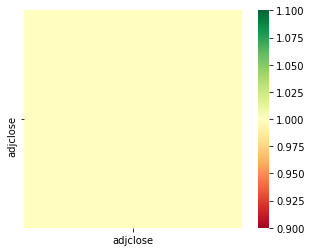

In [11]:
# heatmap was generated using Seaborn's heatmap function 
# (http://seaborn.pydata.org/generated/seaborn.heatmap.html)
# and the following line of code, where df.corr() computes 
# the pairwise correlation between columns:
import seaborn as sns
sns.heatmap(t_combined.corr(), square=True, cmap='RdYlGn')

# another way
corr = feature_target_df.corr() # df with selected features and y value
sns.heatmap(corr, annot=True) # annot shows numeric value for each correlation in the plot

In [9]:
# maybe use this line to get values without the index
t_combined.adjclose.values.reshape(-1,1)

array([[154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [154.79498291],
       [168.26609802],
       [211.545578  ],
       [286.27505493],
       [321.8500061 ],
       [323.33999634],
       [325.11999512],
       [322.32000732],
       [331.5       ],
       [333.45999146],
       [333.45999146],
       [333.45999146],
       [343.98999023],
       [352.83999634],
       [335.8999939 ],
       [338.79998779],
       [342.98999023],
       [342.98999023],
       [342.98999023],
       [352.07998657],
       [351.58999634],
       [351.73001099],
       [349.72000122],
       [358.86999512],
       [358.86999512],
       [358.86999512],
       [366.52999878],
       [360.05999756],
       [364.83999634],
       [353.63000488],
       [361.77999878],
       [361.77999878],
       [361

In [280]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
vec = TfidfVectorizer(ngram_range=(1, 1), analyzer='word', max_features=5_000)
# mdl = LogisticRegression()
mdl = LinearRegression()

In [281]:
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=(
    ('vec', vec),
    ('mdl', mdl)
))



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

In [ ]:
# label_enc = preprocessing.LabelEncoder()
# y_enc = label_enc.fit_transform(y)

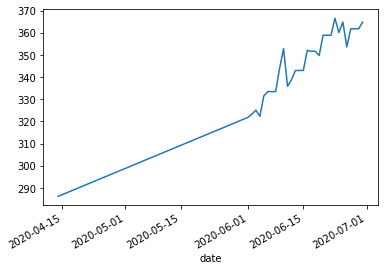

In [263]:
y = t_combined.adjclose
y.index.name = 'date'
y.loc['2020-01-01':'2020-06-30'].plot()

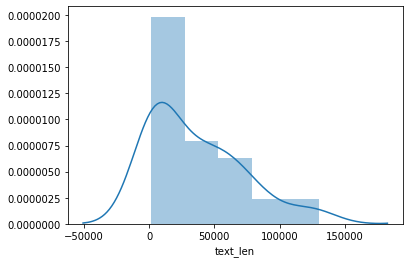

In [276]:
import seaborn as sns
t_combined['text_len'] = t_combined.text.apply(len)
sns.distplot(t_combined.text_len)

In [288]:
X, y = t_combined.text, t_combined.adjclose
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [286]:
test = vec.fit_transform(X)
print(test.shape)

(49, 5000)


In [289]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vec', TfidfVectorizer(max_features=5000)),
                ('mdl', LinearRegression())])

In [292]:
len(vec.get_feature_names())

5000

In [290]:
import joblib
joblib.dump(pipe, 'LinearRegressionTrained.pkl')

['LinearRegressionTrained.pkl']

In [293]:
def make_pred_df(y_true, y_pred):
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
#         'y_pred_proba': y_pred_proba
    })
    
    df['off'] = (df.y_pred-df.y_true)/y_true*100
    
    return df

In [294]:
y_pred = pipe.predict(X_test)
# y_pred_proba = pipe.predict_proba(X_test).max(axis=1)

pred_df = make_pred_df(y_test, y_pred)
pred_df

,y_true,y_pred,off
date,,,
2019-09-06,211.545578,241.257553,14.045189
2020-07-01,364.109985,337.425501,-7.328688
2020-07-03,373.850006,289.919850,-22.450222
2020-06-30,364.799988,340.234322,-6.734010
2020-06-03,325.119995,330.592768,1.683309
2020-06-13,342.989990,271.523717,-20.836256
2020-06-12,338.799988,344.363392,1.642091
2020-06-11,335.899994,341.638951,1.708532
2020-06-17,351.589996,353.793547,0.626739


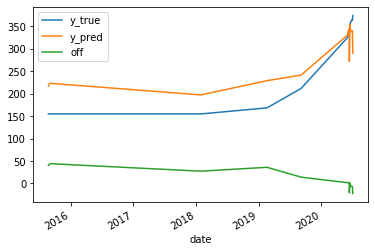

In [296]:
pred_df.plot()

## Count number of news per ticker

In [9]:
res = c.aggregate([
    {'$unwind':'$news'},
#     {'$project':{'_id':0,'ticker':1,'total_news':{'$size':'$news'}}},
    {'$group':{'_id':'$ticker', 'total_news': {'$sum':1}}},
    {'$sort':{'total_news':-1}},
#     {'$limit':10}
], allowDiskUse=True)

# for r in res:
#     print(r)
pd.DataFrame(list(res))

,_id,total_news
0,FOX,6099
1,ADS,1671
2,C,972
3,AAPL,922
4,D,892
...,...,...
500,BWA,56
501,TT,40
502,HWM,36
503,OTIS,19
